# micrograd

In [108]:
import math
import numpy as np
import matplotlib as plt
%matplotlib inline

In [109]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 00 # has gradient 0 -> assuming it does not change L
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"value: {self.data}"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")

# a = Value(2, label="a")
# b = Value(-1, label="b")
# c = Value(100, label="c")
# d = a * b; d.label = "d"
# e = d + c; e.label = "e"
# f = Value(-2.0, label="f")
# L = e * f; L.label = "L"
a = Value(2, label="a")
b = Value(-3, label="b")
c = Value(10, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L1"

In [110]:
from graphviz import Digraph

# TODO
# from https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

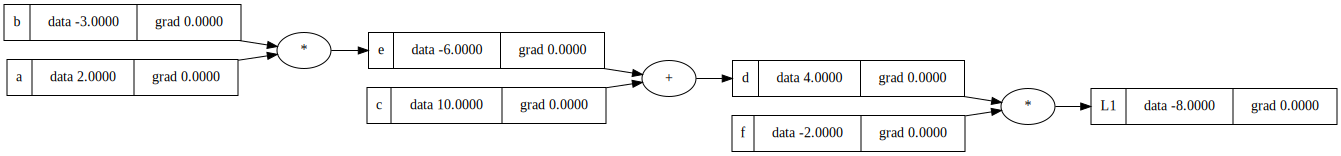

In [111]:
draw_dot(L)

- a, b, c and f are inputs?
- back prop -> calc grad wrt all inputs -> see how it affects it?

In [112]:
def local_test():
    h = 0.0001

    a = Value(2, label="a")
    b = Value(-3, label="b")
    c = Value(10, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L1 = d * f; L1.label = "L1"

    a = Value(2, label="a")
    b = Value(-3, label="b")
    c = Value(10, label="c")
    e = a * b; e.label = "d"
    d = e + c; d.label = "e"
    d.data += h # this is the val of f -> L2 = d*f, dL2/dd = f
    f = Value(-2.0, label="f")
    L2 = d * f; L2.label = "L2"

    # print(L2.data)

    print((L2.data - L1.data)/h)

local_test()

-1.9999999999953388


the "+" node -> routes the grad of the parent to the children -> since $d = \Sigma_i c_i$, for any $i$, $\frac{dd}{dc_i} = 1$

this is when finding the $\frac{dL}{dc_i}$

"*" -> grad = product of all sibling vals 